__Kaggle competition - digit recognizer__

1. [Kaggle competition - digit recognizer](#Kaggle-competition-digit-recognizer)
1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [Initial EDA](#Initial-EDA)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Modeling](#Modeling)
    1. [Model](#Model)
    1. [Utilities](#Utilities)
    1. [Training](#Training)
    1. [Testing](#Testing)
1. [Explanability](#Explanability)
1. [Submission](#Submission)
    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# Standard libary and settings
import os
import sys
import importlib
import itertools
import csv
import copy
from timeit import default_timer as timer
import time

rundate = time.strftime("%Y%m%d")

import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import CounterVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_selection import f_classif, f_regression, VarianceThreshold, SelectFromModel, SelectKBest
import sklearn.gaussian_process as gaussian_process
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder, OneHotEncoder, KBinsDiscretizer, QuantileTransformer, PowerTransformer, MinMaxScaler

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

## Data

<a id = 'Data'></a>

In [4]:
# load data and print dimensions
df_train = pd.read_csv("s3://tdp-ml-datasets/kaggle-mnist//train.csv", sep=",")
df_test = pd.read_csv("s3://tdp-ml-datasets/kaggle-mnist//test.csv", sep=",")

print("Training data dimensions: {}".format(df_train.shape))
print("Test data dimensions: {}".format(df_test.shape))

# separate label from image
df_train_label = df_train["label"]
df_train = df_train.drop(labels="label", axis=1)

Training data dimensions: (42000, 785)
Test data dimensions: (28000, 784)


##### Training data

In [5]:
# train/test split
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train, df_train_label, test_size=0.2
)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('')
print('X_valid shape: {}'.format(X_valid.shape))
print('y_valid shape: {}'.format(y_valid.shape))

X_train shape: (33600, 784)
y_train shape: (33600,)

X_valid shape: (8400, 784)
y_valid shape: (8400,)


In [6]:
# batch depth height width
class DatasetTrainMNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.images.iloc[index].values.astype(np.uint8).reshape((28, 28))
        label = self.labels.iloc[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# transformation instructions
transform = transforms.Compose(
    [
        #     transforms.ToPILImage()
        #     ,transforms.RandomHorizontalFlip(0.5)
        transforms.ToTensor()
    ]
)

# load training data
train_data = DatasetTrainMNIST(images=X_train, labels=y_train, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

print("training data shape: {}".format(train_data.images.shape))

training data shape: (33600, 784)


images batch size: torch.Size([64, 1, 28, 28])
labels batch size: torch.Size([64])


Text(0.5, 1.0, '[8 9 9 7 5 0 7 8 8 2 2 5 9 3 0 1 3 7 6 7 0 9 9 5 6 6 4 4 7 5 7 2 7 8 2 6 9\n 3 6 4 8 5 3 0 5 1 7 4 6 6 8 0 2 0 4 0 1 2 7 4 5 9 9 1]')

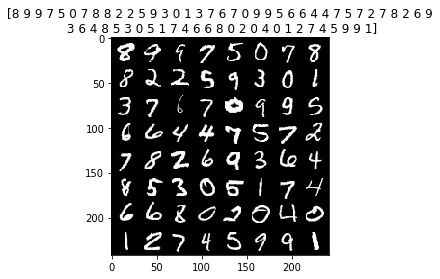

In [7]:
# verify that data was loaded correctly
train_iter = iter(train_loader)
images, labels = train_iter.next()

print("images batch size: {}".format(images.size()))
print("labels batch size: {}".format(labels.size()))

grid = torchvision.utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.title(labels.numpy())

##### Validation data

In [8]:
# validation data
valid_data = DatasetTrainMNIST(images=X_valid, labels=y_valid, transform=transform)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

print("validation data shape: {}".format(valid_data.images.shape))

validation data shape: (8400, 784)


images batch size: torch.Size([64, 1, 28, 28])
labels batch size: torch.Size([64])


Text(0.5, 1.0, '[7 7 0 2 3 8 4 9 4 3 8 4 2 8 1 7 6 3 0 6 9 2 7 1 0 5 6 5 9 7 1 7 1 1 8 1 2\n 7 2 8 5 2 2 7 9 1 9 3 4 6 0 8 7 1 4 8 0 8 6 3 0 4 0 5]')

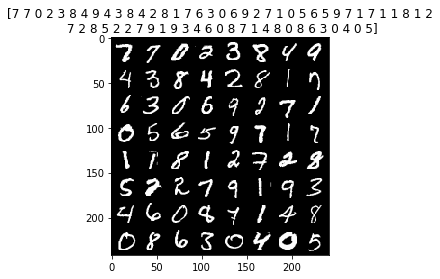

In [9]:
# verify that data was loaded correctly
validIter = iter(valid_loader)
images, labels = validIter.next()

print("images batch size: {}".format(images.size()))
print("labels batch size: {}".format(labels.size()))

grid = torchvision.utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.title(labels.numpy())

##### Test data

In [8]:
# test data loader
class DatasetTestMNIST(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # in this example, we use ToTensor(), so we define the numpy array like (H, W, C)
        image = self.images.iloc[index].values.astype(np.uint8).reshape((28, 28))

        if self.transform is not None:
            image = self.transform(image)

        return image

# transformation instructions
transform = transforms.Compose([
        #     transforms.ToPILImage()
        #     ,transforms.RandomHorizontalFlip(0.5)
        transforms.ToTensor()
    ])

# load test data
test_data = DatasetTestMNIST(images=df_test, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("training data shape: {}".format(test_data.images.shape))

training data shape: (28000, 784)


# Initial EDA

<a id = 'Initial-EDA'></a>

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

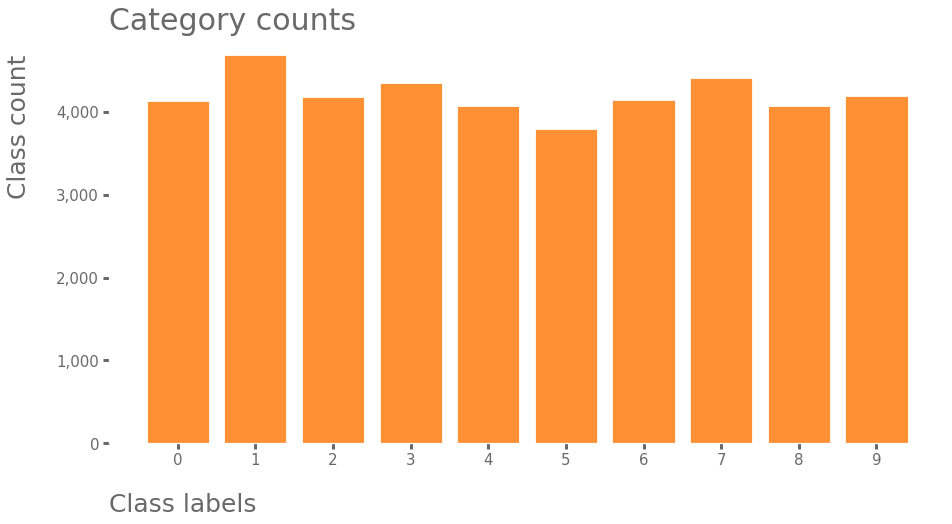

In [15]:
# visualize distribution of class labels
cats, counts = np.unique(df_train_label, return_counts=True)

p = PrettierPlot()
ax = p.make_canvas(
    title="Category counts", x_label="Class labels", y_label="Class count", y_shift=0.6
)
p.bar_v(
    x=cats,
    counts=counts,
    label_rotate=0,
    color=style.style_hex_mid[2],
    y_units="f",
    ax=ax,
)

# Modeling

<a id = 'Modeling'></a>

## Model

<a id = 'Model'></a>

In [10]:
# set layer parameters
channels = 1
filter1, kernel1, padding1, max_pooling1 = 16, 3, 1, 2
filter2, kernel2, padding2, max_pooling2 = 32, 3, 1, 2
filter3, kernel3, padding3, max_pooling3 = 64, 3, 1, 2
dense0, dense1, dense2, dense3 = 64 * 3 * 3, 120, 64, 10

# build model architecture
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=channels,
            out_channels=filter1,
            kernel_size=kernel1,
            padding=padding1,
            stride=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=filter1,
            out_channels=filter2,
            kernel_size=kernel2,
            padding=padding2,
            stride=1,
        )
        self.conv3 = nn.Conv2d(
            in_channels=filter2,
            out_channels=filter3,
            kernel_size=kernel3,
            padding=padding3,
            stride=1,
        )

        # fully connected layers
        self.fc1 = nn.Linear(dense0, dense1)
        self.fc2 = nn.Linear(dense1, dense2)
        self.fc3 = nn.Linear(dense2, dense3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, max_pooling1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, max_pooling2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, max_pooling3)

        x = x.view(-1, dense0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Utilities

<a id = 'Utilities'></a>

In [11]:
# runtime utility function
def timer(start, end):
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print(
        "\tRuntime: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds)
    )

In [12]:
# training loop
def train(model, device, train_loader, optimizer, criterion, start, epoch):
    """
    
    """
    print("-" * 50 + "\n\tEpoch {}\n".format(epoch) + "-" * 50)

    model.train()

    running_loss = 0.0
    running_corrects = 0
    for batch, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, target.squeeze_())
        loss.backward()
        optimizer.step()

        # performance statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target)

        if (batch) % 75 == 0:
            print(
                "Batch [{}/{}]\n\tLoss:\t{:.4f}".format(
                    batch, len(train_loader), loss.item()
                ))
            timer(start, time.time())

    training_loss = running_loss / len(X_train)
    training_accuracy = running_corrects.double() / len(X_train)

    print(
        "Training epoch {}\n\tLoss:\t{:.5f} Accuracy:\t{:.5f}".format(
            epoch, training_loss, training_accuracy
        ))
    timer(start, time.time())
    return training_accuracy, training_loss

In [13]:
# validation loop
def valid(model, device, valid_loader, criterion):
    """
    
    """
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            preds = torch.argmax(output, 1)
            loss = criterion(output, target.squeeze_())
            running_loss += loss.item() + data.size(0)
            running_corrects += torch.sum(preds == target)

    validation_loss = running_loss / len(X_valid)
    validation_accuracy = running_corrects.double() / len(X_valid)

    print("-" * 50)
    print(
        "Validation epoch {}\n\tLoss:\t{:.5f} Accuracy:\t{:.5f}".format(
            epoch, validation_loss, validation_accuracy
        ))
    return validation_accuracy, validation_loss

In [14]:
# test loop
def test(model, device, test_loader, criterion):
    model.eval()
    ans = []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            preds = torch.argmax(output, 1)
            ans.append(preds)
    return ans

In [ ]:
# use TSNE to visualize clustering of observations
from matplotlib import cm
from sklearn.manifold import TSNE


def plot_with_labels(low_d_weights, labels):
    fig = plt.figure(figsize=(15, 10))
    X, Y = low_d_weights[:, 0], low_d_weights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title("Visualize last layer")
    plt.show()


# execute CNN
for epoch in range(epoch):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, computes gradients
        optimizer.step()  # apply gradients

        if step % 300 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print(
                "Step: {} | train loss : {} | test accuracy: {}".format(
                    step, loss.data.item(), accuracy
                )
            )

            tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
            plot_only = 500
            low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
            labels = test_y.numpy()[:plot_only]
            plot_with_labels(low_dim_embs, labels)
# plt.ioff()

## Training

<a id = 'Training'></a>

In [15]:
# initialize model, criterion and optimizer
net = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# set device to cuda if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)
bestWeights = copy.deepcopy(model.state_dict())

In [ ]:
# execute train and validation loops
bestAccuracy = 0.0
epochs = 100
start = time.time()

writer = SummaryWriter()
for epoch in range(epochs):
    # train fit
    training_accuracy, training_loss = train(
        model=model,
        device=device,
        train_loader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        start=start,
        epoch=epoch,
    )

    # validation fit
    validation_accuracy, validation_loss = valid(
        model=model, device=device, valid_loader=valid_loader, criterion=criterion
    )

    #     writer.add_scalars('data/scalar_group', {'xsinx': n_iter * np.sin(n_iter),
    #                                              'xcosx': n_iter * np.cos(n_iter),
    #                                              'arctanx': np.arctan(n_iter)}, n_iter)

    # collect loss scalars for TensorBoarder
    writer.add_scalars(
        "data/loss", {"training": training_loss, "validation": validation_loss}, epoch
    )
    # collect accuracy scalars for TensorBoarder
    writer.add_scalars(
        "data/accuracy",
        {"training": training_accuracy, "validation": validation_accuracy},
        epoch,
    )

    #     writer.add_scalar('data/training_loss', training_loss, epoch)
    #     writer.add_scalar('data/training_accuracy', training_accuracy, epoch)

    # evaluate and update best accuracy
    if bestAccuracy < validation_accuracy:
        bestAccuracy = validation_accuracy
        bestWeights = copy.deepcopy(model.state_dict())
        print("Accuracy improved\n\n")
    else:
        print("No improvement\n\n")
print("Training complated:")
timer(start, time.time())
print("Best validation accuracy: {:4f}".format(bestAccuracy))

# export TensorBoard data
writer.export_scalars_to_json("all_scalars.json")
writer.close()

# save entire model
torch.save(model, "saved_model.pth")

## Testing

<a id = 'Testing'></a>

In [ ]:
# evaluate model using test data
ans = test(model=model, device=device, test_loader=test_loader, criterion=criterion)
ans = torch.cat(ans).cpu().numpy()

# Explanability

<a id = 'Explanability'></a>

In [ ]:
shap.DeepExplainer

LIME

image section: https://github.com/marcotcr/lime

# TensorBoard

<a id = 'TensorBoard'></a>

In [21]:
#
train_iter = iter(train_loader)
images, labels = train_iter.next()

grid = torchvision.utils.make_grid(images)

In [22]:
#
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [23]:
#
for n_iter in range(100):

    dummy_s1 = torch.rand(1)
    dummy_s2 = torch.rand(1)
    # data grouping by `slash`
    writer.add_scalar("data/scalar1", dummy_s1[0], n_iter)
    writer.add_scalar("data/scalar2", dummy_s2[0], n_iter)

    writer.add_scalars(
        "data/scalar_group",
        {
            "xsinx": n_iter * np.sin(n_iter),
            "xcosx": n_iter * np.cos(n_iter),
            "arctanx": np.arctan(n_iter),
        },
        n_iter,
    )

In [24]:
#
writer.export_scalars_to_json("all_scalars.json")
writer.add_image("images", grid, 0)
writer.add_graph(model, images)

In [18]:
#
writer.close()

# Submission

<a id = 'Submission'></a>

In [ ]:
# .oad entire model
model = torch.load("saved_model.pth")

In [ ]:
#
results = pd.read_csv("data/sample_submission.csv")
results["Label"] = ans

results.to_csv("data/submission.csv", index=False)

# Misc

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(p=0.25),
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
#
batch_size = 8
n_classes = 10

x = torch.randn(batch_size, n_classes, requires_grad=True)
print(x)

# predictions
output = F.log_softmax(x, dim=a1)
print(output)

# actuals
target = torch.LongTensor(batch_size).random_(n_classes)
print(target)

preds = []
targets = []
for i in range(batch_size):
    output = F.log_softmax(torch.randn(batch_size, n_classes), dim=1)
    target = torch.LongTensor(batch_size).random_(n_classes)

    _, pred = torch.max(output, dim=1)
    preds.append(pred.data)
    targets.append(target.data)

torch.cat(preds)
torch.cat(targets)